<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Proyecto_SNS_JuanArmasAleman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Autor:
Juan Airam Armas Alemán

#Github:
https://github.com/JuanArmas/BigDataSNS/blob/main/Proyecto_SNS_JuanArmasAleman.ipynb

In [1]:
#Importar librerías y módulos
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn.externals
import joblib
from google.colab import files
from sklearn.model_selection import train_test_split, KFold, cross_val_score,cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors



In [ ]:
# print("pandas version:", pd.__version__)
# print("numpy version:", np.__version__)
# print("seaborn version:", sns.__version__)
# print("sklearn version:", sklearn.__version__)
# print("joblib version:", joblib.__version__)


##Carga y normalización de datos:


#### Cargamos datos desde repo local e indicamos con codificación ISO-8859-1, que cree el dataframe y que separe por ","

In [2]:
def upload_files ():
  #Lee el archivo desde local
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    #df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep=',')
    df_Casen = pd.read_csv(io.StringIO(uploaded[fn].decode('ISO-8859-1')), sep=';')
    return df_Casen

In [3]:
df_Casen = upload_files()
df_Casen

Saving 01_casen_2017_muestra.csv to 01_casen_2017_muestra.csv
User uploaded file "01_casen_2017_muestra.csv" with length 14464 bytes


,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,Aimara,Indigena,No pobres,12.0,250000.0,3.0,3.0
1,Mujer,1,21,No pertenece a ningún pueblo indígena,No indigena,No pobres,7.0,211091.0,3.0,3.0
2,Hombre,0,24,No pertenece a ningún pueblo indígena,No indigena,No pobres,12.0,281750.0,4.0,4.0
3,Hombre,0,28,No pertenece a ningún pueblo indígena,No indigena,Pobres extremos,12.0,311750.0,4.0,4.0
4,Hombre,0,26,No pertenece a ningún pueblo indígena,No indigena,Pobres extremos,15.0,341667.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,No pertenece a ningún pueblo indígena,No indigena,No pobres,10.0,NaN,4.0,4.0
195,Mujer,1,10,No pertenece a ningún pueblo indígena,No indigena,No pobres,NaN,NaN,4.0,4.0
196,Hombre,0,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,Mujer,1,37,No pertenece a ningún pueblo indígena,No indigena,No pobres,15.0,NaN,4.0,4.0


### Transformación de variables categóricas a numéricas
##### incido sobre todo en la columna "etnia", ya que es la que más diversidad tiene

In [4]:
df_Casen['etnia'].replace(['Aimara','No pertenece a ningún pueblo indígena','Mapuche','Diaguita',' ','Quechua','Collas',
                                  'Yámana o Yagán','Atacameño (Likan-Antai)','Kawashkar o Alacalufes','Rapa-Nui o Pascuenses'],
                                   [2,3,4,5,3,6,7,8,9,10,11], inplace=True)
df_Casen['pobreza_ingreso'].replace(['No pobres','Pobres extremos','Pobres no extremos'],[12, 13,14], inplace=True)
df_Casen['es_indigena'].replace(['Indigena','No indigena'],[15,16], inplace=True)
# Rellenamos los espacios vacios cambiando los NaN por valores medios
columns_to_impute = ['etnia', 'es_indigena','pobreza_ingreso', 'esc', 'ingreso', 'qaut', 'qautr']
# Rellenar los NaN con la media de cada columna
for column in columns_to_impute:
  mean_value = df_Casen[column].mean()
  df_Casen[column].fillna(round(mean_value), inplace=True)
# Escalamos con MinMaxScaler la columna ingresos para acotar sus rangos de valores entre 0-1 para que sea más manejable
column_to_scale = 'ingreso'
scaler = MinMaxScaler()
# Ajustar y transformar la columna 'ingreso'
df_Casen[[column_to_scale]] = scaler.fit_transform(df_Casen[[column_to_scale]])

# Se convierten a enteros todos salvo la columna ingreso, ya que sus valores normalizados se comprenden entre 0-1
df_Casen['pobreza_ingreso'] = df_Casen['pobreza_ingreso'].astype(int)
df_Casen['etnia'] = df_Casen['etnia'].astype(int)
df_Casen['es_indigena'] = df_Casen['es_indigena'].astype(int)
df_Casen['esc'] = df_Casen['esc'].astype(int)
df_Casen['qaut'] = df_Casen['qaut'].astype(int)
df_Casen['qautr'] = df_Casen['qautr'].astype(int)


# Se muestra el conjunto de datos con los valores normalizados
df_Casen

,sexo,sexo_cod,edad,etnia,es_indigena,pobreza_ingreso,esc,ingreso,qaut,qautr
0,Mujer,1,56,2,15,12,12,0.055197,3,3
1,Mujer,1,21,3,16,12,7,0.046417,3,3
2,Hombre,0,24,3,16,12,12,0.062362,4,4
3,Hombre,0,28,3,16,13,12,0.069131,4,4
4,Hombre,0,26,3,16,13,15,0.075883,2,2
...,...,...,...,...,...,...,...,...,...,...
194,Hombre,0,16,3,16,12,10,0.145496,4,4
195,Mujer,1,10,3,16,12,12,0.145496,4,4
196,Hombre,0,43,5,16,12,12,0.145496,3,3
197,Mujer,1,37,3,16,12,15,0.145496,4,4


##Usando herramientas: Matriz de correlación

<ipython-input-5-011457a3fb8e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_Casen.corr(), square=True, annot=True)


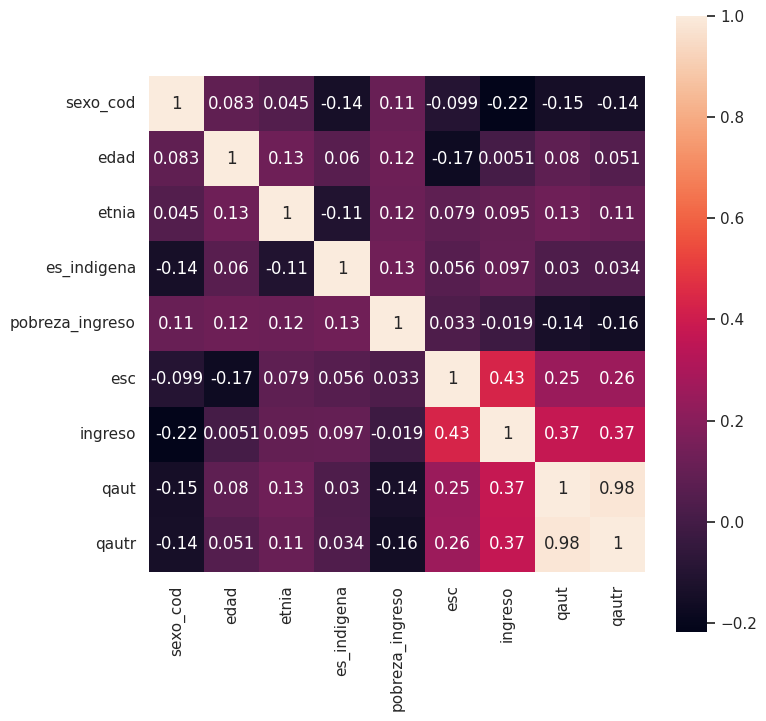

In [5]:
sns.set()
plt.figure(figsize=(8,8))  # Tamaño personalizado de la figura
sns.heatmap(df_Casen.corr(), square=True, annot=True)
plt.show()

##Usando herramientas: SelectKbest


In [6]:
name_features_casen = ['sexo_cod', 'edad', 'es_indigena', 'etnia', 'esc', 'ingreso', 'qaut', 'qautr']
X_casen = df_Casen[name_features_casen]
y_casen = df_Casen['pobreza_ingreso']

X_train_casen, X_test_casen, y_train_casen, y_test_casen = train_test_split(X_casen, y_casen, test_size=.2, random_state=42)

X_train_casen_ar = X_train_casen.to_numpy()
y_train_casen_ar = y_train_casen.to_numpy()
X_test_casen_ar = X_test_casen.to_numpy()
# Usar SelectKBest con f_classif para seleccionar las k características que están más correlacionadas
selector = SelectKBest(f_classif, k=4) # En K le indicamos el número de características que queremos seleccionar

# Muestra las características seleccionadas
X_train_casen_char_selected = selector.fit(X_train_casen_ar, y_train_casen_ar)

char_selected = X_train_casen_char_selected.get_feature_names_out(name_features_casen)

# Con este método selecciona las mejores características y filas que no están correlacionadas
X_train_casen_selected = selector.fit_transform(X_train_casen_ar, y_train_casen_ar)
X_test_casen_selected = selector.transform(X_test_casen_ar)

char_selected


array(['etnia', 'ingreso', 'qaut', 'qautr'], dtype=object)

## Usando NaiveBayes modelo (...)

In [7]:
# Definir las características (features) y la variable objetivo (target) para el modelo
features = df_Casen[['sexo_cod', 'etnia', 'qautr']]
target = df_Casen['pobreza_ingreso']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

names = ["GaussianNB", "MultiNomialNB", 'BernoulliNB', 'ComplementNB','CategoricalNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB(),CategoricalNB()]

cv = KFold(n_splits=5, shuffle=True)
total_scores_cv = []

for name, clf in zip(names, classifiers):
    fold_accuracy = []
    for train_fold, test_fold in cv.split(X_train):
        f_train_x = X_train.iloc[train_fold]
        f_train_y = y_train.iloc[train_fold]
        clf.fit(f_train_x, f_train_y)
        y_pred = clf.predict(X_train.iloc[test_fold])
        acc = accuracy_score(y_train.iloc[test_fold], y_pred)
        fold_accuracy.append(acc)
    total_scores_cv.append(fold_accuracy)

total_scores_mean = [sum(scores)/len(scores) for scores in total_scores_cv]
total_scores_scv = []

###Sin Cross Validation

In [8]:
print("Sin Cross Validation")
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("Modelo: %s =%4.0f%%" % (name, score*100))

Sin Cross Validation
Modelo: GaussianNB =  55%
Modelo: MultiNomialNB =  60%
Modelo: BernoulliNB =  62%
Modelo: ComplementNB =  40%
Modelo: CategoricalNB =  60%


###Con Cross Validation

In [9]:
for name, clfCV in zip(names, classifiers):
    # Utilizamos cross_val_score para realizar la validación cruzada
    scores = cross_val_score(clfCV, X_train, y_train, cv=5)  # cv=5 indica 5-fold cross-validation

    # Imprimimos los resultados de la validación cruzada
    print("Modelo: %s =  %3.0f%%" % (name, np.mean(scores*100)))

Modelo: GaussianNB =   74%
Modelo: MultiNomialNB =   75%
Modelo: BernoulliNB =   75%
Modelo: ComplementNB =   56%
Modelo: CategoricalNB =   75%


# Usando KNN

Max Value uniform: 0.7671370967741936 (k=5)
Max Value distance: 0.7737903225806452 (k=4)


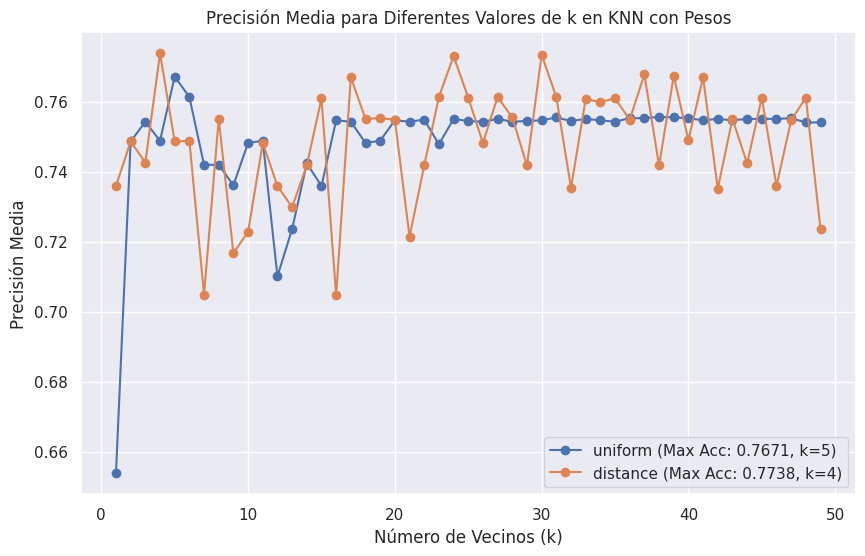

In [10]:
# Definir diferentes valores de k y pesos para probar
k_values = range(1, 50)
weights_list = ['uniform', 'distance']

cv = KFold(n_splits=5, shuffle=True)
plt.figure(figsize=(10, 6))

for i, weights in enumerate(weights_list):
    total_scores = []
    for n_neighbors in k_values:
        fold_accuracy = []
        knn = KNeighborsClassifier(n_neighbors, weights=weights)

        for train_fold, test_fold in cv.split(X_train):
            f_train_x = X_train.iloc[train_fold]
            f_train_y = y_train.iloc[train_fold]

            # Entrenamiento y ejecución del modelo
            knn.fit(X=f_train_x, y=f_train_y)
            y_pred = knn.predict(X=X_train.iloc[test_fold])

            # Evaluación del modelo
            acc = accuracy_score(y_train.iloc[test_fold], y_pred)
            fold_accuracy.append(acc)

        total_scores.append(np.mean(fold_accuracy))

    # Imprimir información sobre la precisión y el valor de k correspondiente al máximo
    max_acc = max(total_scores)
    best_k = np.argmax(total_scores) + 1
    print(f'Max Value {weights}: {max_acc} (k={best_k})')

    # Mostrar gráficamente los resultados para cada conjunto de pesos
    plt.plot(k_values, total_scores, marker='o', label=f'{weights} (Max Acc: {max_acc:.4f}, k={best_k})')

plt.title('Precisión Media para Diferentes Valores de k en KNN con Pesos')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión Media')
plt.legend()
plt.grid(True)
plt.show()


#Matriz de confusión

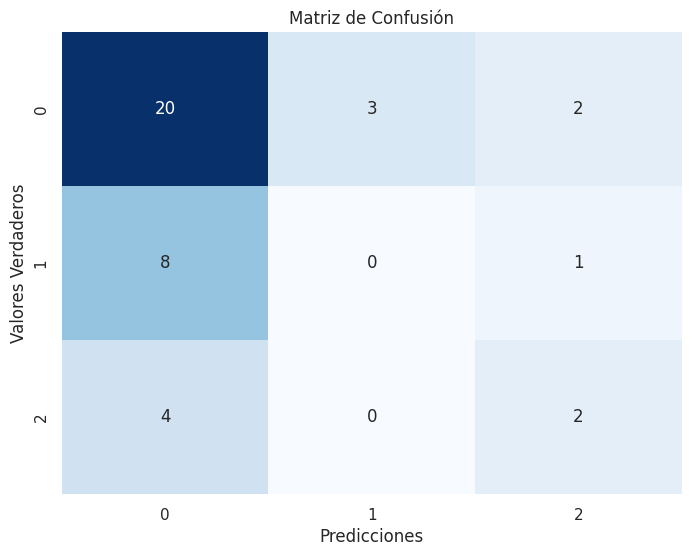

In [11]:
# Usar tus datos de entrenamiento para ajustar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

# Predecir en los datos de prueba
y_pred = knn.predict(X_test)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()


# Random forest

Mejor número de árboles (n_estimators): 200
Precisión media con el mejor número de árboles: 0.760483870967742


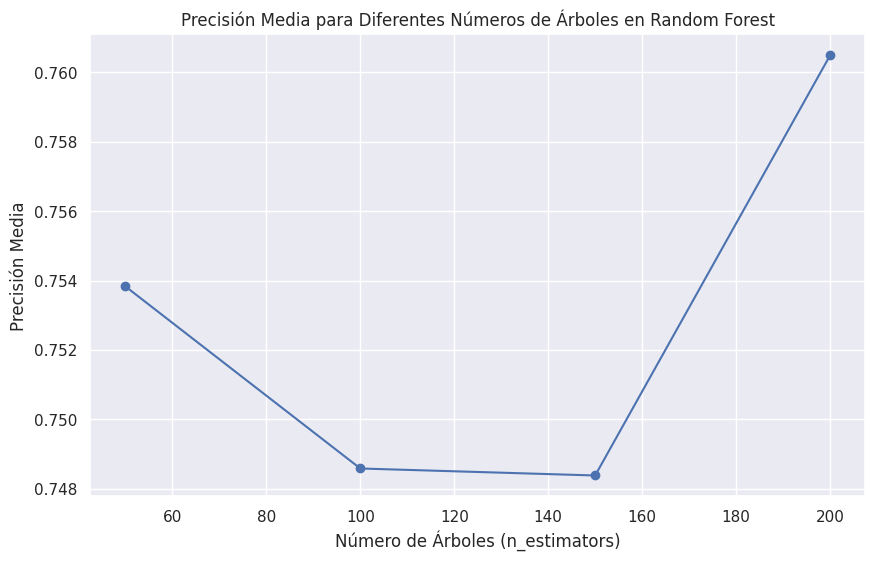

In [27]:

# Definir diferentes valores para el número de árboles (n_estimators)
n_estimators_values = [50, 100, 150, 200]

# Configurar la validación cruzada (K-Fold)
cv = KFold(n_splits=5, shuffle=True)
total_scores_cv = []

# Bucle principal para probar diferentes valores de n_estimators
for n_estimators in n_estimators_values:
    fold_accuracy = []

    # Validación cruzada: dividir los datos en conjuntos de entrenamiento y prueba
    for train_fold, test_fold in cv.split(X_train):
        f_train_x = X_train.iloc[train_fold]
        f_train_y = y_train.iloc[train_fold]

        # Crear y entrenar el modelo Random Forest con el número de árboles actual
        rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf_model.fit(f_train_x, f_train_y)

        # Realizar predicciones en el conjunto de prueba y evaluar la precisión
        y_pred = rf_model.predict(X_train.iloc[test_fold])
        acc = accuracy_score(y_train.iloc[test_fold], y_pred)
        fold_accuracy.append(acc)

    # Guardar la precisión de cada fold para el valor actual de n_estimators
    total_scores_cv.append(fold_accuracy)

# Calcular la precisión media para cada valor de n_estimators
total_scores_mean = [np.mean(scores) for scores in total_scores_cv]

# Encontrar el mejor valor de n_estimators basado en la precisión media
best_n_estimators = n_estimators_values[np.argmax(total_scores_mean)]

# Imprimir resumen de la precisión del modelo con los mejores parámetros
print(f"Mejor número de árboles (n_estimators): {best_n_estimators}")
print(f"Precisión media con el mejor número de árboles: {max(total_scores_mean)}")

# Mostrar gráficamente los resultados
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, total_scores_mean, marker='o', linestyle='-', color='b')
plt.title('Precisión Media para Diferentes Números de Árboles en Random Forest')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()

# Exportar Fichero

Usando Joblib

In [22]:
for name, clfCV in zip(names, classifiers):
  # Entrenamos el modelo con todo el conjunto de entrenamiento
    clfCV.fit(X_train, y_train)
  # Utilizamos cross_val_score para realizar la validación cruzada
    scores = cross_val_score(clfCV, X_train, y_train, cv=5)

    # Guardar el modelo y los resultados de la validación cruzada
    joblib.dump(clfCV, f"{name}_modelo_entrenado_casen.pkl")
    joblib.dump(scores, f"{name}_cross_val_scores.pkl")

    print(f"Modelo {name} entrenado y resultados de validación cruzada guardados.")
    print(f"Modelo guardado como {name}_modelo_entrenado_casen.pkl")
    print(f"Modelo guardado como {name}_cross_val_scores.pkl")
    print("Modelo: %s =  %3.2f%%" % (name, np.mean(scores*100)),"\n")

Modelo GaussianNB entrenado y resultados de validación cruzada guardados.
Modelo guardado como GaussianNB_modelo_entrenado_casen.pkl
Modelo guardado como GaussianNB_cross_val_scores.pkl
Modelo: GaussianNB =  73.59% 

Modelo MultiNomialNB entrenado y resultados de validación cruzada guardados.
Modelo guardado como MultiNomialNB_modelo_entrenado_casen.pkl
Modelo guardado como MultiNomialNB_cross_val_scores.pkl
Modelo: MultiNomialNB =  75.48% 

Modelo BernoulliNB entrenado y resultados de validación cruzada guardados.
Modelo guardado como BernoulliNB_modelo_entrenado_casen.pkl
Modelo guardado como BernoulliNB_cross_val_scores.pkl
Modelo: BernoulliNB =  75.48% 

Modelo ComplementNB entrenado y resultados de validación cruzada guardados.
Modelo guardado como ComplementNB_modelo_entrenado_casen.pkl
Modelo guardado como ComplementNB_cross_val_scores.pkl
Modelo: ComplementNB =  55.95% 

Modelo CategoricalNB entrenado y resultados de validación cruzada guardados.
Modelo guardado como Categorica

In [ ]:
# pip list

In [23]:
clf_entrenado = joblib.load('MultiNomialNB_modelo_entrenado_casen.pkl')
clf_precison = joblib.load('MultiNomialNB_cross_val_scores.pkl')
nombre_modelo = clf_entrenado.__class__.__name__
print(f"Modelo sin cross Validation -> {nombre_modelo} ",int(clf_entrenado.score(X_test, y_test)*100),"%") # Obtenemos la precisión sin CV
print(f"Modelo con cross Validation -> {nombre_modelo} ",int(np.mean(clf_precison*100)),"%") # Obtenemos la precisión con CV

Modelo sin cross Validation -> MultinomialNB  60 %
Modelo con cross Validation -> MultinomialNB  75 %
